## Instance Balanced Augmentation
more information, please visit https://www.jiqizhixin.com/articles/2019-12-14-5.

In [1]:
import json
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import copy
from tqdm import tqdm

### 1. 导入数据加载和保存路径

In [65]:
# load json file
with open('seacoco/train_new.json') as g:
    train = json.load(g)  
    
# image path
train_img_path = 'seacoco/train/'

# aug_img save_path
aug_img_path = 'seacoco/ahf_aug_train/'

# aug_json save_path
aug_json_path = 'seacoco/ahf_aug_train.json'

In [32]:
print('The keys in annotation dataset:\n', list(train.keys()))
print("train['images'][0]:\n", train['images'][0])
print("train['annotations'][0]:\n", train['annotations'][0])
print("train['categories']:\n", train['categories'])

dict_keys(['images', 'type', 'annotations', 'categories'])

打印增强前的类别信息

In [37]:
class_freq_dict = {}

# init class_fre_dict
for cls in train['categories']:
    class_freq_dict[cls['id']] = 0

# count the instance number of each class
for ann in train['annotations']:
    class_freq_dict[ann['category_id']] += 1

# print out class frequency
print("The instance number of each class:")
for cls_id in list(class_freq_dict.keys()):
    for cat in train['categories']:
        if cat['id'] == cls_id:
            print(cat['name'], ': ', class_freq_dict[cls_id])

The instance number of each class:
holothurian :  4574
echinus :  18676
scallop :  5554
starfish :  5704


### 2.正式开始实例平衡增强
首先要了解两个变量：
- SCALE_RATIO是指增强前图片放大比率。
- AUG_NUM是横纵坐标上各要平均选几个滑动点，如果是3且滑动窗口左上角点在水平方向上滑动范围是0-99，那么滑动窗口将依次滑动到0,到33,再到99，一张图最后会有3（横）x3（纵）张增强后的图。

In [55]:
SCALE_RATIO = 1.5 # the scaling ratio
AUG_NUM = 3 # 横纵坐标上各要平均选几个滑动点

由于原数据集存在类别不平衡问题（实例数量：海参4574，海胆18676，扇贝5554和海星5704），所以打算使用阿里之前提出的一个实例平衡增强方法去增强数据解决不平衡问题，首先先把原图放大1.5倍，然后用原图原始尺寸大小作为滑窗大小，以滑窗形式水平平均地移动三次，垂直平均地移动三次，最后1张图会得到9张相当于shift和scale后的增强图片。在滑动中发现如果不对滑动窗口做限制，会加重类别不平衡，因为海胆数量太多，且滑动结果会有很多单张只有一个扇贝的情况从而导致扇贝很多。因此对滑动窗口进行限制：滑动窗口内含海胆就不要该窗口，滑动窗口内仅有一个扇贝的不要要。最后增强数据和原数据合并后的实例数量是：海参13016，海胆18676，扇贝13287和海星12322。类别平衡许多了且该增强模仿了水下手持拍摄设备从远到近的拍摄过程。

In [66]:
# 获取所有图片名
all_img_names = [i['file_name'] for i in train['images']]

# 初始化标注信息
images = []
annotations = []

img_count = 0 # 记录有多少滑动窗口是含有标注的（即为有效窗口）
ann_count = 0 # 记录有多少有效annotations
for img_name in tqdm(all_img_names):
    
    # 导入图片并resize
    img = cv.imread(train_img_path + img_name)
    h, w = img.shape[0:2]
    resize_img = cv.resize(img, (int(w * SCALE_RATIO), int(h * SCALE_RATIO)))

    # 滑动最大范围
    w_scope = (SCALE_RATIO - 1) * w
    h_scope = (SCALE_RATIO - 1) * h

    # 间隔移动的坐标起始点列表
    win_x1s = list(np.linspace(0, w_scope, AUG_NUM))
    win_y1s = list(np.linspace(0, h_scope, AUG_NUM))
    
    win_x1 = 0
    win_y1 = 0
    count = 0 # 记录该图片下滑动窗口的数量

    for win_y1 in win_y1s:
        for win_x1 in win_x1s:
            count += 1
            win_x1 = int(win_x1)
            win_y1 = int(win_y1)
            win_x2 = win_x1 + w
            win_y2 = win_y1 + h
            win_img = copy.deepcopy(resize_img[win_y1:win_y2,win_x1:win_x2,:])

            # 根据图名字找到id
            for imgs in train['images']:
                if img_name == imgs['file_name']:
                    image_id = imgs['id']
            
            cat_ids = [] # 收集该滑动窗口内所有category_id
            # 根据图id找到标注
            has_ann_flag = False # 该滑动窗口内是否有标注
            for anns in train['annotations']:
                if anns['image_id'] == image_id:

                    # resize bbox
                    bbox_x1 = int(anns['bbox'][0] * SCALE_RATIO)
                    bbox_y1 = int(anns['bbox'][1] * SCALE_RATIO)
                    bbox_x2 = int((anns['bbox'][0] + anns['bbox'][2]) * SCALE_RATIO)
                    bbox_y2 = int((anns['bbox'][1] + anns['bbox'][3]) * SCALE_RATIO)

                    # 更新bbox annotations(标注框在窗口内不改变，标注框相交则只取相交部分的内容)
                    bbox_x1_new = max(win_x1, bbox_x1) - win_x1
                    bbox_y1_new = max(win_y1, bbox_y1) - win_y1
                    bbox_x2_new = min(win_x2, bbox_x2) - win_x1
                    bbox_y2_new = min(win_y2, bbox_y2) - win_y1
                            
                    if bbox_x1_new >= bbox_x2_new or bbox_y1_new >= bbox_y2_new:
                        continue
                    else:
                        cat_ids.append(anns['category_id'])
                        
            # 排除掉‘含有海胆’或‘只有一个扇贝’的滑动窗口
            if cat_ids != [] and 2 not in cat_ids and list(np.unique(cat_ids)) != [3]:
                # 根据图id找到标注
                has_ann_flag = False # 该滑动窗口内是否有标注
                for anns in train['annotations']:
                    if anns['image_id'] == image_id:

                        # resize bbox
                        bbox_x1 = int(anns['bbox'][0] * SCALE_RATIO)
                        bbox_y1 = int(anns['bbox'][1] * SCALE_RATIO)
                        bbox_x2 = int((anns['bbox'][0] + anns['bbox'][2]) * SCALE_RATIO)
                        bbox_y2 = int((anns['bbox'][1] + anns['bbox'][3]) * SCALE_RATIO)

                        # 更新bbox annotations(标注框在窗口内不改变，标注框相交则只取相交部分的内容)
                        bbox_x1_new = max(win_x1, bbox_x1) - win_x1
                        bbox_y1_new = max(win_y1, bbox_y1) - win_y1
                        bbox_x2_new = min(win_x2, bbox_x2) - win_x1
                        bbox_y2_new = min(win_y2, bbox_y2) - win_y1
                        if bbox_x1_new >= bbox_x2_new or bbox_y1_new >= bbox_y2_new:
                            continue
                        else:
                            ann_count += 1
                            if has_ann_flag == False:
                                img_count += 1 # 该滑动窗口有标注的话就+1
                                has_ann_flag = True
                                
                            # 如果该滑动窗口含有标注，加入标注数据annotations里
                            annotations.append({'segmentation':[],
                                               'area': int(bbox_y2_new - bbox_y1_new) * int(bbox_x2_new - bbox_x1_new),
                                               'iscrowd':anns['iscrowd'],
                                               'image_id':img_count,
                                               'bbox':[bbox_x1_new, bbox_y1_new, bbox_x2_new - bbox_x1_new, bbox_y2_new - bbox_y1_new],
                                               'category_id':anns['category_id'],
                                               'ignore':anns['ignore'],
                                               'id':ann_count})
                                 
                # 如果该滑动窗口含有标注，加入标注数据images里且保存该图片
                if has_ann_flag == True:
                    fn = img_name.split('.')[0] + '_' + str(count) + '.jpg'
                    images.append({'file_name':fn,
                                  'height':w,
                                  'width':h,
                                  'id':img_count})
                    cv.imwrite(aug_img_path + fn, win_img)

aug_anns = {'images':images, 'annotations':annotations, 'categories':train['categories']}
with open(aug_json_path, 'w') as save_f:
    save_f.write(json.dumps(aug_anns))
print('Finishing instance-balanced augmentation')








  0%|          | 0/4619 [00:00<?, ?it/s]






  0%|          | 2/4619 [00:00<05:18, 14.49it/s]






  0%|          | 4/4619 [00:00<05:13, 14.70it/s]






  0%|          | 6/4619 [00:00<05:13, 14.73it/s]






  0%|          | 8/4619 [00:00<07:38, 10.06it/s]






  0%|          | 9/4619 [00:01<15:13,  5.05it/s]






  0%|          | 11/4619 [00:01<14:11,  5.41it/s]






  0%|          | 12/4619 [00:01<17:15,  4.45it/s]






  0%|          | 13/4619 [00:02<19:31,  3.93it/s]






  0%|          | 14/4619 [00:02<21:11,  3.62it/s]






  0%|          | 15/4619 [00:02<22:26,  3.42it/s]






  0%|          | 16/4619 [00:03<22:40,  3.38it/s]






  0%|          | 17/4619 [00:03<23:01,  3.33it/s]






  0%|          | 18/4619 [00:03<21:34,  3.55it/s]






  0%|          | 19/4619 [00:03<22:00,  3.48it/s]






  0%|          | 20/4619 [00:04<22:08,  3.46it/s]






  0%|          | 21/4619 [00:04<21:43,  3.53it/s]






  0%|          | 22/4619 [00:04<21:26,  3.57it/s]







  5%|▌         | 235/4619 [01:15<43:14,  1.69it/s]






  5%|▌         | 236/4619 [01:15<39:49,  1.83it/s]






  5%|▌         | 237/4619 [01:16<40:28,  1.80it/s]






  5%|▌         | 238/4619 [01:16<31:21,  2.33it/s]






  5%|▌         | 239/4619 [01:16<24:46,  2.95it/s]






  5%|▌         | 240/4619 [01:16<20:30,  3.56it/s]






  5%|▌         | 241/4619 [01:17<36:23,  2.00it/s]






  5%|▌         | 242/4619 [01:18<28:44,  2.54it/s]






  5%|▌         | 243/4619 [01:18<23:07,  3.15it/s]






  5%|▌         | 244/4619 [01:18<18:55,  3.85it/s]






  5%|▌         | 245/4619 [01:18<21:41,  3.36it/s]






  5%|▌         | 246/4619 [01:18<18:05,  4.03it/s]






  5%|▌         | 247/4619 [01:19<28:38,  2.54it/s]






  5%|▌         | 248/4619 [01:20<32:00,  2.28it/s]






  5%|▌         | 249/4619 [01:20<25:15,  2.88it/s]






  5%|▌         | 250/4619 [01:20<20:54,  3.48it/s]






  5%|▌         | 251/4619 [01:20<17:33,  4.15it/s]






  5%|▌         | 252/4619 [01:2

 10%|▉         | 445/4619 [02:14<07:48,  8.92it/s]






 10%|▉         | 446/4619 [02:14<07:43,  9.00it/s]






 10%|▉         | 447/4619 [02:14<07:48,  8.90it/s]






 10%|▉         | 448/4619 [02:14<08:01,  8.66it/s]






 10%|▉         | 449/4619 [02:14<07:48,  8.89it/s]






 10%|▉         | 450/4619 [02:14<07:47,  8.91it/s]






 10%|▉         | 451/4619 [02:14<07:38,  9.08it/s]






 10%|▉         | 452/4619 [02:14<07:39,  9.07it/s]






 10%|▉         | 453/4619 [02:14<07:35,  9.14it/s]






 10%|▉         | 454/4619 [02:14<07:25,  9.35it/s]






 10%|▉         | 455/4619 [02:15<07:29,  9.26it/s]






 10%|▉         | 456/4619 [02:15<07:33,  9.18it/s]






 10%|▉         | 457/4619 [02:15<07:53,  8.80it/s]






 10%|▉         | 458/4619 [02:15<08:20,  8.32it/s]






 10%|▉         | 459/4619 [02:15<08:26,  8.21it/s]






 10%|▉         | 460/4619 [02:15<08:30,  8.15it/s]






 10%|▉         | 461/4619 [02:16<14:05,  4.92it/s]






 10%|█         | 462/4619 [02:1

 14%|█▍        | 654/4619 [03:16<08:38,  7.65it/s]






 14%|█▍        | 655/4619 [03:16<08:14,  8.02it/s]






 14%|█▍        | 656/4619 [03:17<08:04,  8.17it/s]






 14%|█▍        | 657/4619 [03:17<07:56,  8.31it/s]






 14%|█▍        | 658/4619 [03:17<07:46,  8.49it/s]






 14%|█▍        | 659/4619 [03:17<07:46,  8.48it/s]






 14%|█▍        | 660/4619 [03:17<07:46,  8.49it/s]






 14%|█▍        | 661/4619 [03:17<08:06,  8.13it/s]






 14%|█▍        | 662/4619 [03:17<07:57,  8.28it/s]






 14%|█▍        | 663/4619 [03:17<07:47,  8.46it/s]






 14%|█▍        | 664/4619 [03:17<07:50,  8.41it/s]






 14%|█▍        | 665/4619 [03:18<07:42,  8.56it/s]






 14%|█▍        | 666/4619 [03:18<07:45,  8.49it/s]






 14%|█▍        | 667/4619 [03:18<08:12,  8.03it/s]






 14%|█▍        | 668/4619 [03:18<07:58,  8.26it/s]






 14%|█▍        | 669/4619 [03:18<07:53,  8.34it/s]






 15%|█▍        | 670/4619 [03:18<07:43,  8.52it/s]






 15%|█▍        | 671/4619 [03:1

 19%|█▊        | 862/4619 [04:44<18:15,  3.43it/s]






 19%|█▊        | 863/4619 [04:45<26:57,  2.32it/s]






 19%|█▊        | 864/4619 [04:46<24:33,  2.55it/s]






 19%|█▊        | 865/4619 [04:46<23:49,  2.63it/s]






 19%|█▊        | 866/4619 [04:47<28:43,  2.18it/s]






 19%|█▉        | 867/4619 [04:47<32:57,  1.90it/s]






 19%|█▉        | 868/4619 [04:48<38:16,  1.63it/s]






 19%|█▉        | 869/4619 [04:49<42:14,  1.48it/s]






 19%|█▉        | 870/4619 [04:50<44:28,  1.40it/s]






 19%|█▉        | 871/4619 [04:50<33:52,  1.84it/s]






 19%|█▉        | 872/4619 [04:50<26:30,  2.36it/s]






 19%|█▉        | 873/4619 [04:50<21:10,  2.95it/s]






 19%|█▉        | 874/4619 [04:50<17:45,  3.52it/s]






 19%|█▉        | 875/4619 [04:51<27:46,  2.25it/s]






 19%|█▉        | 876/4619 [04:51<21:59,  2.84it/s]






 19%|█▉        | 877/4619 [04:51<18:11,  3.43it/s]






 19%|█▉        | 878/4619 [04:51<15:16,  4.08it/s]






 19%|█▉        | 879/4619 [04:5

 27%|██▋       | 1237/4619 [05:32<02:43, 20.70it/s]






 27%|██▋       | 1240/4619 [05:32<02:51, 19.73it/s]






 27%|██▋       | 1243/4619 [05:32<02:57, 19.06it/s]






 27%|██▋       | 1245/4619 [05:32<03:33, 15.81it/s]






 27%|██▋       | 1247/4619 [05:32<03:40, 15.32it/s]






 27%|██▋       | 1249/4619 [05:32<03:29, 16.05it/s]






 27%|██▋       | 1251/4619 [05:33<03:48, 14.75it/s]






 27%|██▋       | 1253/4619 [05:33<04:55, 11.40it/s]






 27%|██▋       | 1255/4619 [05:33<06:09,  9.10it/s]






 27%|██▋       | 1257/4619 [05:33<06:22,  8.79it/s]






 27%|██▋       | 1259/4619 [05:34<05:41,  9.83it/s]






 27%|██▋       | 1261/4619 [05:34<05:13, 10.72it/s]






 27%|██▋       | 1264/4619 [05:34<04:23, 12.73it/s]






 27%|██▋       | 1266/4619 [05:34<04:20, 12.87it/s]






 27%|██▋       | 1268/4619 [05:34<03:53, 14.38it/s]






 27%|██▋       | 1270/4619 [05:34<03:39, 15.27it/s]






 28%|██▊       | 1272/4619 [05:34<03:30, 15.93it/s]






 28%|██▊      

 38%|███▊      | 1757/4619 [06:05<02:12, 21.65it/s]






 38%|███▊      | 1760/4619 [06:05<02:02, 23.31it/s]






 38%|███▊      | 1763/4619 [06:05<02:00, 23.64it/s]






 38%|███▊      | 1766/4619 [06:05<01:59, 23.97it/s]






 38%|███▊      | 1769/4619 [06:06<01:59, 23.85it/s]






 38%|███▊      | 1772/4619 [06:06<01:57, 24.24it/s]






 38%|███▊      | 1775/4619 [06:06<01:54, 24.78it/s]






 38%|███▊      | 1778/4619 [06:06<01:51, 25.52it/s]






 39%|███▊      | 1781/4619 [06:06<01:49, 26.02it/s]






 39%|███▊      | 1784/4619 [06:06<01:48, 26.17it/s]






 39%|███▊      | 1787/4619 [06:06<01:46, 26.51it/s]






 39%|███▉      | 1790/4619 [06:06<01:43, 27.25it/s]






 39%|███▉      | 1794/4619 [06:06<01:35, 29.51it/s]






 39%|███▉      | 1798/4619 [06:07<01:29, 31.63it/s]






 39%|███▉      | 1802/4619 [06:07<01:24, 33.29it/s]






 39%|███▉      | 1806/4619 [06:07<01:22, 34.24it/s]






 39%|███▉      | 1810/4619 [06:07<01:23, 33.55it/s]






 39%|███▉     

 53%|█████▎    | 2425/4619 [06:36<01:08, 31.90it/s]






 53%|█████▎    | 2429/4619 [06:36<01:05, 33.45it/s]






 53%|█████▎    | 2433/4619 [06:36<01:23, 26.27it/s]






 53%|█████▎    | 2436/4619 [06:37<01:22, 26.50it/s]






 53%|█████▎    | 2440/4619 [06:37<01:15, 28.93it/s]






 53%|█████▎    | 2444/4619 [06:37<01:09, 31.30it/s]






 53%|█████▎    | 2448/4619 [06:37<01:05, 33.15it/s]






 53%|█████▎    | 2452/4619 [06:37<01:02, 34.59it/s]






 53%|█████▎    | 2456/4619 [06:37<01:06, 32.68it/s]






 53%|█████▎    | 2460/4619 [06:37<01:23, 25.72it/s]






 53%|█████▎    | 2464/4619 [06:38<01:15, 28.55it/s]






 53%|█████▎    | 2468/4619 [06:38<01:10, 30.32it/s]






 54%|█████▎    | 2472/4619 [06:38<01:06, 32.42it/s]






 54%|█████▎    | 2476/4619 [06:38<01:03, 34.00it/s]






 54%|█████▎    | 2480/4619 [06:38<01:00, 35.20it/s]






 54%|█████▍    | 2484/4619 [06:38<01:05, 32.42it/s]






 54%|█████▍    | 2488/4619 [06:38<01:02, 34.02it/s]






 54%|█████▍   

 65%|██████▍   | 2997/4619 [07:07<00:47, 33.84it/s]






 65%|██████▍   | 3001/4619 [07:07<00:54, 29.79it/s]






 65%|██████▌   | 3005/4619 [07:07<00:52, 30.96it/s]






 65%|██████▌   | 3009/4619 [07:07<00:49, 32.60it/s]






 65%|██████▌   | 3013/4619 [07:07<00:50, 31.67it/s]






 65%|██████▌   | 3017/4619 [07:07<00:53, 29.91it/s]






 65%|██████▌   | 3021/4619 [07:07<00:54, 29.38it/s]






 65%|██████▌   | 3024/4619 [07:08<00:55, 28.88it/s]






 66%|██████▌   | 3027/4619 [07:08<00:55, 28.83it/s]






 66%|██████▌   | 3030/4619 [07:08<00:55, 28.89it/s]






 66%|██████▌   | 3033/4619 [07:08<01:08, 23.20it/s]






 66%|██████▌   | 3036/4619 [07:08<01:08, 23.20it/s]






 66%|██████▌   | 3039/4619 [07:08<01:23, 18.84it/s]






 66%|██████▌   | 3042/4619 [07:08<01:21, 19.43it/s]






 66%|██████▌   | 3045/4619 [07:09<01:13, 21.38it/s]






 66%|██████▌   | 3048/4619 [07:09<01:17, 20.39it/s]






 66%|██████▌   | 3051/4619 [07:09<01:12, 21.74it/s]






 66%|██████▌  

 77%|███████▋  | 3551/4619 [07:39<01:04, 16.51it/s]






 77%|███████▋  | 3555/4619 [07:39<00:55, 19.07it/s]






 77%|███████▋  | 3558/4619 [07:39<00:58, 18.11it/s]






 77%|███████▋  | 3560/4619 [07:40<00:59, 17.79it/s]






 77%|███████▋  | 3562/4619 [07:40<00:59, 17.76it/s]






 77%|███████▋  | 3566/4619 [07:40<00:50, 20.92it/s]






 77%|███████▋  | 3569/4619 [07:40<00:49, 21.16it/s]






 77%|███████▋  | 3572/4619 [07:40<00:48, 21.59it/s]






 77%|███████▋  | 3575/4619 [07:40<00:48, 21.61it/s]






 77%|███████▋  | 3578/4619 [07:40<00:45, 23.12it/s]






 78%|███████▊  | 3581/4619 [07:40<00:44, 23.24it/s]






 78%|███████▊  | 3584/4619 [07:40<00:42, 24.43it/s]






 78%|███████▊  | 3587/4619 [07:41<00:54, 18.95it/s]






 78%|███████▊  | 3590/4619 [07:41<00:55, 18.39it/s]






 78%|███████▊  | 3593/4619 [07:41<00:55, 18.33it/s]






 78%|███████▊  | 3597/4619 [07:41<00:48, 21.17it/s]






 78%|███████▊  | 3600/4619 [07:41<00:46, 21.84it/s]






 78%|███████▊ 

 90%|████████▉ | 4152/4619 [08:11<01:32,  5.06it/s]






 90%|████████▉ | 4153/4619 [08:11<01:24,  5.50it/s]






 90%|████████▉ | 4154/4619 [08:12<03:08,  2.47it/s]






 90%|████████▉ | 4155/4619 [08:13<02:33,  3.03it/s]






 90%|████████▉ | 4156/4619 [08:13<02:08,  3.61it/s]






 90%|████████▉ | 4157/4619 [08:13<01:48,  4.25it/s]






 90%|█████████ | 4158/4619 [08:13<02:11,  3.51it/s]






 90%|█████████ | 4159/4619 [08:14<02:26,  3.14it/s]






 90%|█████████ | 4160/4619 [08:14<02:03,  3.72it/s]






 90%|█████████ | 4161/4619 [08:14<01:47,  4.24it/s]






 90%|█████████ | 4162/4619 [08:15<03:02,  2.50it/s]






 90%|█████████ | 4163/4619 [08:15<02:29,  3.04it/s]






 90%|█████████ | 4164/4619 [08:15<02:04,  3.65it/s]






 90%|█████████ | 4165/4619 [08:15<02:16,  3.33it/s]






 90%|█████████ | 4166/4619 [08:16<01:55,  3.92it/s]






 90%|█████████ | 4167/4619 [08:17<03:47,  1.99it/s]






 90%|█████████ | 4168/4619 [08:17<02:59,  2.51it/s]






 90%|█████████

 96%|█████████▌| 4425/4619 [08:52<00:32,  5.99it/s]






 96%|█████████▌| 4426/4619 [08:53<00:31,  6.18it/s]






 96%|█████████▌| 4427/4619 [08:53<00:30,  6.35it/s]






 96%|█████████▌| 4428/4619 [08:53<00:34,  5.49it/s]






 96%|█████████▌| 4429/4619 [08:53<00:32,  5.89it/s]






 96%|█████████▌| 4430/4619 [08:53<00:29,  6.33it/s]






 96%|█████████▌| 4431/4619 [08:53<00:27,  6.80it/s]






 96%|█████████▌| 4432/4619 [08:54<00:26,  6.94it/s]






 96%|█████████▌| 4433/4619 [08:54<00:26,  7.12it/s]






 96%|█████████▌| 4434/4619 [08:54<00:25,  7.28it/s]






 96%|█████████▌| 4435/4619 [08:54<00:25,  7.28it/s]






 96%|█████████▌| 4436/4619 [08:54<00:26,  6.92it/s]






 96%|█████████▌| 4437/4619 [08:54<00:26,  6.89it/s]






 96%|█████████▌| 4438/4619 [08:54<00:24,  7.28it/s]






 96%|█████████▌| 4439/4619 [08:54<00:23,  7.64it/s]






 96%|█████████▌| 4440/4619 [08:55<00:22,  7.89it/s]






 96%|█████████▌| 4441/4619 [08:55<00:22,  7.86it/s]






 96%|█████████

Finishing instance-balanced augmentation


打印增强的数据下各类别数量情况：

In [67]:
print("The augmentation image number: %d" % len(aug_anns['images']))
print("The augmentation annotation number: %d" % len(aug_anns['annotations']))
print("")
class_freq_dict = {}

# init class_fre_dict
for cls in aug_anns['categories']:
    class_freq_dict[cls['id']] = 0

# count the instance number of each class
for ann in aug_anns['annotations']:
    class_freq_dict[ann['category_id']] += 1

# print out class frequency
print("The instance number of each class:")
for cls_id in list(class_freq_dict.keys()):
    for cat in aug_anns['categories']:
        if cat['id'] == cls_id:
            print(cat['name'], ': ', class_freq_dict[cls_id])

The augmentation image number: 6963
The augmentation annotation number: 22793

The instance number of each class:
holothurian :  8442
echinus :  0
scallop :  7733
starfish :  6618


对比增强前后各类别数量情况：

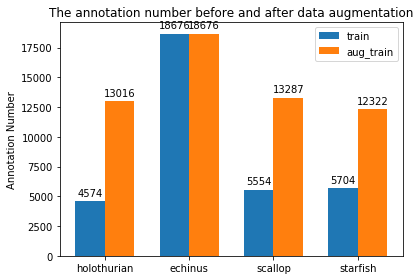

In [68]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


labels = ['holothurian', 'echinus', 'scallop', 'starfish']
train_means = [4574, 18676, 5554, 5704]
aug_train_means = [8442+4574, 18676, 7733+5554, 6618+5704]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_means, width, label='train')
rects2 = ax.bar(x + width/2, aug_train_means, width, label='aug_train')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Annotation Number')
ax.set_title('The annotation number before and after data augmentation')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

将增强的数据标注追加到未增强的原数据标注中去：

In [56]:
with open('seacoco/ahf_aug_train.json', 'r') as f:
    atrain = json.load(f)

with open('seacoco/train_new.json', 'r') as f1:
    train = json.load(f1)

img_id = 6963
ann_id = 22793
old2newimgid_dict = {}
for t_img in train['images']:
    img_id += 1
    atrain['images'].append({'file_name':t_img['file_name'],
                            'height':t_img['height'],
                            'width':t_img['width'],
                            'id':img_id})
    old2newimgid_dict[t_img['id']] = img_id
    
for t_ann in train['annotations']:
    ann_id += 1 
    atrain['annotations'].append({'segmentation':[],
                                 'area':t_ann['area'],
                                 'iscrowd':t_ann['iscrowd'],
                                 'image_id':old2newimgid_dict[t_ann['image_id']],
                                 'bbox':t_ann['bbox'],
                                 'category_id':t_ann['category_id'],
                                 'id':ann_id,
                                 'ignore':t_ann['ignore']})
    
with open('seacoco/new_ahf_aug_train.json', 'w') as save_f:
    json.dump(atrain, save_f)